In [1]:
!pip install vidaug
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
# import keras_metrics as km
# from keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
import math
import vidaug.augmentors as va
from sklearn.utils import shuffle

In [2]:
data_dir = "/content/drive/MyDrive/video_data"
img_height , img_width = 64, 64
seq_len = 16

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
X_=np.load('/content/drive/MyDrive/data/save_X_flip_shear_withsafe.npy')
Y_=np.load('/content/drive/MyDrive/data/save_Y_flip_shear_withsafe.npy')
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.2, shuffle=True, random_state=36)
del X_
del Y_
# X_, Y_ = shuffle(X_,Y_, random_state = 36)

In [5]:
model = Sequential()

model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),strides = (2,2), return_sequences = True, input_shape = (seq_len, img_height, img_width, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),strides = (2,2), return_sequences = True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3),strides = (2,2), return_sequences = True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 128, kernel_size = (3, 3),strides = (2,2), return_sequences = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(8, activation = "softmax"))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 16, 31, 31, 32)    40448     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 31, 31, 32)    128       
_________________________________________________________________
activation (Activation)      (None, 16, 31, 31, 32)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 16, 15, 15, 32)    73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 15, 15, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 15, 15, 32)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 16, 7, 7, 64)      2

In [6]:
def schedular(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * math.exp(0.1*(10-epoch))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
36/36 [==============================] - 641s 18s/step - loss: 1.9136 - accuracy: 0.2844 - val_loss: 1.9544 - val_accuracy: 0.2077
Epoch 2/25
36/36 [==============================] - 631s 18s/step - loss: 1.5051 - accuracy: 0.4179 - val_loss: 1.9941 - val_accuracy: 0.1648
Epoch 3/25
36/36 [==============================] - 630s 18s/step - loss: 1.2470 - accuracy: 0.5295 - val_loss: 1.9467 - val_accuracy: 0.2156
Epoch 4/25
36/36 [==============================] - 629s 18s/step - loss: 0.9805 - accuracy: 0.6275 - val_loss: 1.8254 - val_accuracy: 0.2796
Epoch 5/25
36/36 [==============================] - 633s 18s/step - loss: 0.7238 - accuracy: 0.7369 - val_loss: 1.8865 - val_accuracy: 0.2883
Epoch 6/25
36/36 [==============================] - 631s 18s/step - loss: 0.5344 - accuracy: 0.8169 - val_loss: 2.2928 - val_accuracy: 0.2805
Epoch 7/25
36/36 [==============================] - 633s 18s/step - loss: 0.3531 - accuracy: 0.8742 - val_loss: 2.4987 - val_accuracy: 0.2778
Epoch 

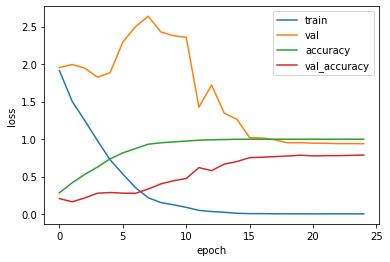

In [7]:
opt = tf.keras.optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
# earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = tf.keras.callbacks.LearningRateScheduler(schedular)
 
history = model.fit(x = X_train, y = y_train, epochs=25, batch_size = 128, shuffle=True, validation_split=0.2, callbacks=callbacks)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val','accuracy','val_accuracy'])
plt.show()


In [9]:
model.save('/content/drive/MyDrive/model/final_model.h5')

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

print('accuracy score : {}'.format(accuracy_score(y_pred, y_test)))


              precision    recall  f1-score   support

           0       0.79      0.76      0.78       277
           1       0.81      0.76      0.78       219
           2       0.76      0.84      0.80       283
           3       0.77      0.75      0.76       232
           4       0.85      0.86      0.86       188
           5       0.70      0.77      0.74       146
           6       0.80      0.64      0.71        81

    accuracy                           0.78      1426
   macro avg       0.78      0.77      0.78      1426
weighted avg       0.78      0.78      0.78      1426

accuracy score : 0.782608695652174
